# Experiment with FCN for detection
### Idea:
Train network (Converted to fully convolutional neural network) with one size, than use the same classifer with different multiple sizes to create a feature grid.

### Refereces:
* https://github.com/leonardoaraujosantos/DLMatFramework/blob/master/learn/python_notebooks/Tensorflow/TF_MNIST_CNN.ipynb
* https://github.com/MarvinTeichmann/tensorflow-fcn

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Display some images

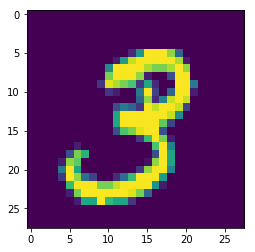

In [2]:
imgDigit = mnist.train.images[1]
plt.imshow(imgDigit.reshape([28,28]))
plt.show()

Shape: (1568,)


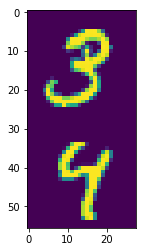

In [3]:
imgDigit_first = mnist.train.images[1]
imgDigit_second = mnist.train.images[2]
imgDigits = np.concatenate((imgDigit_first, imgDigit_second), axis=0)
print('Shape:',imgDigits.shape)
plt.imshow(imgDigits.reshape([56,28]))
plt.show()

## Utility Functions

In [5]:
def weight_variable(shape):
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
    #w = tf.Variable(initializer(shape=shape), name="weights")        
        
    #initial = tf.truncated_normal(shape, stddev=0.1)
    #return tf.Variable(initial)
    return tf.Variable(initializer(shape=shape))

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [6]:
def conv2d(x, W, pad='SAME'):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding=pad)    

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

## Define Network

In [7]:
# Create placeholders (I/O for our model/graph)
#x = tf.placeholder(tf.float32, shape=[None, 784])
x = tf.placeholder("float", None)
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Convert the feature vector to a (-1)x28x28x1 image
# The -1 has the same effect as the "None" value, and will
# be used to inform a variable batch size
#x_image = tf.reshape(x, [-1,28,28,1])
x_image = tf.reshape(x, [-1,28,28,1])

# First layer
W_conv1 = weight_variable([7, 7, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second layer
W_conv2 = weight_variable([3, 3, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Third layer
W_conv3 = weight_variable([3, 3, 64, 128])
b_conv3 = bias_variable([128])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Forth layer
W_conv4 = weight_variable([1, 1, 128, 64])
b_conv4 = bias_variable([64])
h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
#h_pool4 = max_pool_2x2(h_conv4)
h_pool4 = h_conv4

# Final layer (Converted to FCN)
W_final = weight_variable([4, 4, 64, 10])
b_final = bias_variable([10])
h_final = tf.nn.relu(conv2d(h_pool4, W_final, 'VALID') + b_final)

# Last output layer (But first need to convert 1x1x10 to 10)
#y_conv = tf.reshape(h_final, [])
y_conv = tf.squeeze(h_final)

## Define loss

In [8]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Initialize graph

In [9]:
init = tf.global_variables_initializer()

# Avoid allocating the whole memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

#sess = tf.Session()
sess.run(init)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("/tmp/mnist_demo/1")
writer.add_graph(sess.graph)

## Train network

In [10]:
for i in range(2000):
    # Get batch of 50 images
    batch = mnist.train.next_batch(50)
    
    # Print each 100 epochs
    if i%100 == 0:
        # Calculate train accuracy
        train_accuracy = accuracy.eval(session=sess, feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    
    # Train actually here
    train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.12
step 100, training accuracy 0.52
step 200, training accuracy 0.54
step 300, training accuracy 0.7
step 400, training accuracy 0.6
step 500, training accuracy 0.68
step 600, training accuracy 0.86
step 700, training accuracy 0.72
step 800, training accuracy 0.78
step 900, training accuracy 0.78
step 1000, training accuracy 0.8
step 1100, training accuracy 0.82
step 1200, training accuracy 0.78
step 1300, training accuracy 0.58
step 1400, training accuracy 0.84
step 1500, training accuracy 0.8
step 1600, training accuracy 0.84
step 1700, training accuracy 0.72
step 1800, training accuracy 0.76
step 1900, training accuracy 0.78


In [11]:
print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Test Accuracy: 0.7769


## Inference with single image
Here we just to inference on the same size that we trained

In [12]:
print('Original shape:',imgDigit_first.shape)
print(np.argmax(sess.run(y_conv, feed_dict={x: imgDigit_first.reshape(-1,784), keep_prob: 1.0})))
print(np.argmax(sess.run(y_conv, feed_dict={x: imgDigit_second.reshape(-1,784), keep_prob: 1.0})))

Original shape: (784,)
3
4


## Inference with tiled image
On this example we give to the network a concatenated image

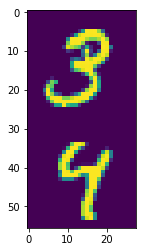

Input shape: (1568,)
Result shape: (2, 10)
[3 4]


In [24]:
plt.imshow(imgDigits.reshape([56,28]))
plt.show()
reshaped_digits = imgDigits.reshape(-1)
result = sess.run(y_conv, feed_dict={x: reshaped_digits, keep_prob: 1.0})
print('Input shape:',reshaped_digits.shape)
print('Result shape:',result.shape)
print(np.argmax(result, axis=1))